# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open(r"../additional_materials/anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}


Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints 

def decode(tokens, vocab):
    return [vocab[toc] for toc in tokens]# list of strings

In [8]:
encode(cut_text[0], char2int)

[208,
 78,
 106,
 123,
 80,
 78,
 122,
 111,
 149,
 71,
 142,
 144,
 197,
 106,
 27,
 122,
 12,
 144,
 78,
 122,
 14,
 106,
 78,
 16,
 78,
 122,
 82,
 105,
 69,
 191,
 143,
 78,
 82,
 122,
 143,
 149,
 94,
 197,
 191,
 149,
 142,
 144,
 14,
 98,
 122,
 14,
 149,
 71,
 197,
 71,
 197,
 122,
 9,
 142,
 143,
 144,
 191,
 149,
 106,
 123,
 143,
 207,
 71,
 197,
 122,
 80,
 106,
 149,
 16,
 197,
 140,
 149,
 71,
 197,
 35,
 122,
 91,
 149,
 80,
 122,
 16,
 14,
 142,
 122,
 105,
 191,
 78,
 65,
 204,
 71,
 149,
 143,
 78,
 27,
 122,
 94,
 106,
 197,
 143,
 3]

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [9]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """
    Encodes a batch of sentences (integer indices) into binary one-hot representation.
    
    Args:
        int_words (torch.Tensor): Tensor of size (batch_size, seq_len) containing word indices.
        vocab_size (int): Size of the vocabulary.

    Returns:
        torch.Tensor: One-hot encoded tensor of size (batch_size, seq_len, vocab_size).
    """
    words_one_hot = torch.zeros(
        (int_words.numel(), vocab_size), dtype=torch.float32, device=int_words.device
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten().long()] = 1.0
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    return words_one_hot


Проверьте ваш код.

In [10]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить эмбеддинги и дополнять последовательность до максимальной длины.

In [11]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list

In [60]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode("<pad>")
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, idx):
        text = self.cut_text[idx]
        encoded = self.tokenizer.encode(text)
        encoded = encoded[:self.max_len]  # Ограничиваем длину
        input_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        target_sequence = torch.full((self.max_len,), self.pad_index, dtype=torch.long)
        
        # Заполняем входную и целевую последовательность
        input_sequence[:len(encoded) - 1] = torch.tensor(encoded[:-1])
        target_sequence[1:len(encoded)] = torch.tensor(encoded[1:])
        
        return input_sequence, target_sequence

In [13]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [14]:
for batch in dataloader:
    break
batch[1].shape

torch.Size([16, 512])

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [15]:
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from typing import Tuple

class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        
        # Токенизатор для кодирования и декодирования
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size # размер словаря
        
        # RNN (или LSTM) слой
        self.rnn = nn.LSTM(
            input_size=self.vocab_size,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.drop_prob,
            batch_first=True,
        )
        
        # Dropout для регуляризации
        self.dropout = nn.Dropout(self.drop_prob)
        
        # Полносвязный слой: преобразует состояние RNN в логиты
        self.fc = nn.Linear(self.hidden_dim, self.vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        # One-hot кодирование входной последовательности
        x = one_hot_encode(x, vocab_size=self.vocab_size)
        
        # Упаковка последовательностей для эффективности
        packed_embeds = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        # Прогон через LSTM
        packed_outputs, hidden = self.rnn(packed_embeds)
        
        # Распаковка выхода обратно в тензор
        outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)
        
        # Dropout для регуляризации
        outputs = self.dropout(outputs)
        
        # Преобразование выхода RNN в логиты
        logits = self.fc(outputs)
        return logits, hidden

    def init_hidden(self, batch_size: int, device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:
        # Инициализация начального скрытого состояния нулями
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        return h0, c0

    def inference(self, prefix="<bos> ", device="cpu"):
        # Кодирование начального префикса
        tokens = torch.tensor(self.tokenizer.encode(prefix), dtype=torch.long, device=device).unsqueeze(0)
        
        # Создание one-hot представления
        inputs = one_hot_encode(tokens, vocab_size=self.vocab_size)
        
        # Инициализация скрытого состояния
        hidden = self.init_hidden(batch_size=1, device=device)
        
        # Генерация префикса
        outputs, hidden = self.rnn(inputs, hidden)
        logits = self.fc(outputs)
        
        # Семплирование токена
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        
        # Остановка: достижение максимальной длины или EOS-токена
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, vocab_size=self.vocab_size)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)
        
        # Декодирование в строку
        return self.tokenizer.decode(tokens.squeeze().tolist())

Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [16]:
batch_size = 16
seq_length = 512
n_hidden = 128
n_layers = 6
drop_prob = 0.1
lr = 0.1

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [17]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    # Обнуляем градиенты
    optimizer.zero_grad()

    # Извлекаем данные из пакета
    inputs, targets = train_batch
    batch_size, seq_len = inputs.shape

    # Переносим данные на нужное устройство (например, GPU)
    inputs, targets = inputs.to(device), targets.to(device)

    # Прямой проход через модель
    lengths = (inputs != 0).sum(dim=1)  # или другая логика для определения длин
    logits, _ = model(inputs, lengths)  # Получаем логиты от модели

    # Переходим от логитов к потере
    # targets нужно сдвигать на 1, чтобы правильно сравнить предсказания и настоящие метки
    loss = criterion(logits.view(-1, vocab_size), targets.view(-1))

    # Обратный проход
    loss.backward()

    # Обновление весов
    optimizer.step()

    return loss


Инициализируйте модель, функцию потерь и оптимизатор.

In [24]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cuda')
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [25]:
model.eval()  # Переключаем модель в режим оценки (inference)

# Шаг 3: Генерация текста
prefix = "<bos> "  # Начальный токен последовательности
generated_sequence = model.inference(prefix=prefix, device="cuda")

# Шаг 4: Вывод результата
print("Сгенерированная последовательность необученной моделью:")
print(generated_sequence)


Сгенерированная последовательность необученной моделью:
<bos><bos> <eos>СЖ事☺老人新AπМhаЦ́的fj<eos>


In [26]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [27]:
for train_batch in dataloader:
    inputs, targets = train_batch
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")
    print(targets)
    break

Inputs shape: torch.Size([16, 512])
Targets shape: torch.Size([16, 512])
tensor([[214,  91, 191,  ..., 214, 214, 214],
        [214,  20, 149,  ..., 214, 214, 214],
        [214,  20, 149,  ..., 214, 214, 214],
        ...,
        [214, 187, 149,  ..., 214, 214, 214],
        [214,  20, 142,  ..., 214, 214, 214],
        [214, 151,  14,  ..., 214, 214, 214]])


In [28]:
for batch_idx, train_batch in enumerate(dataloader):
    inputs, targets = train_batch
    print(f"Batch {batch_idx}: Inputs shape = {inputs.shape}, Targets shape = {targets.shape}")
    break

Batch 0: Inputs shape = torch.Size([16, 512]), Targets shape = torch.Size([16, 512])


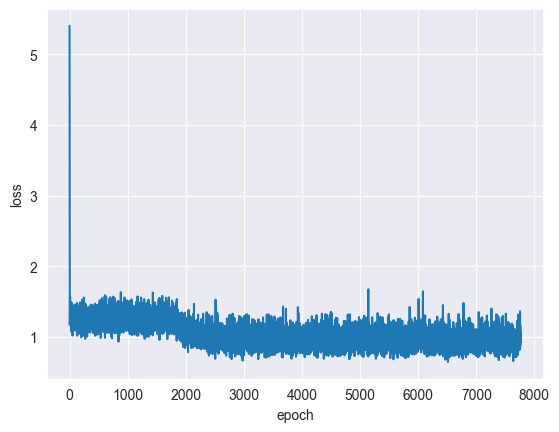

Epoch [2/5], Step [100], Loss: 0.8150
Epoch [2/5], Step [200], Loss: 1.0294
Epoch [2/5], Step [300], Loss: 1.1431
Epoch [2/5], Step [400], Loss: 0.9548
Epoch [2/5], Step [500], Loss: 1.0173
Epoch [2/5], Step [600], Loss: 0.7895
Epoch [2/5], Step [700], Loss: 0.9674
Epoch [2/5], Step [800], Loss: 1.0423
Epoch [2/5], Step [900], Loss: 0.9236
Epoch [2/5], Step [1000], Loss: 1.0404
Epoch [2/5], Step [1100], Loss: 0.9618
Epoch [2/5], Step [1200], Loss: 0.9906
Epoch [2/5], Step [1300], Loss: 0.9256
Epoch [2/5], Step [1400], Loss: 1.1013
Epoch [2/5], Step [1500], Loss: 1.0647
Epoch [2/5], Step [1600], Loss: 0.9376
Epoch [2/5], Step [1700], Loss: 0.8398
Epoch [2/5], Step [1800], Loss: 0.9222
Epoch [2/5], Step [1900], Loss: 1.0000
Epoch [2/5], Step [2000], Loss: 0.8437
Epoch [2/5], Step [2100], Loss: 0.8996
Epoch [2/5], Step [2200], Loss: 0.9899
Epoch [2/5], Step [2300], Loss: 1.1194
Epoch [2/5], Step [2400], Loss: 1.1276
Epoch [2/5], Step [2500], Loss: 0.8143
Epoch [2/5], Step [2600], Loss: 0.

KeyboardInterrupt: 

In [29]:
losses = []
num_epochs = 5

# Основной цикл обучения
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0  # Суммарные потери за эпоху
    model.train()  # Переключение в режим тренировки

    for batch_idx, train_batch in enumerate(dataloader):  # train_loader — DataLoader с батчами
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cuda')
        losses.append(loss.item())  # Запись потерь
        epoch_loss += loss.item()

        # Логгирование каждые 100 батчей
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx + 1}], Loss: {loss.item():.4f}")

    # Сохранение весов после каждой эпохи
    torch.save(model.state_dict(), f"rnn_epoch_{epoch}.pt")
    print(f"Epoch {epoch} completed. Average Loss: {epoch_loss / len(dataloader):.4f}")

    # Визуализация потерь
    plot_losses(losses)

# Финальное сохранение модели
torch.save(model.state_dict(), "rnn_final.pt")
print("Training completed and model saved.")

In [28]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cuda')
model.load_state_dict(torch.load('rnn_epoch_1.pt'))

<All keys matched successfully>

In [31]:
[model.inference("<bos>", device='cuda') for _ in range(10)]

['<bos><bos><eos>м-!<pad>д<pad>нооедтирнюов н-ьн<pad>ира! <pad>р<pad>к<pad>   <pad><pad>т<pad>оеи зое <pad> йщ те-с тсти<pad>а<pad>п л <pad>о чпо<pad>ж<pad>  ж<pad>лшу  поав<pad>а<pad><pad><pad><pad><pad>л<pad><pad>п<pad>п а<pad>км<pad><pad>  <pad><pad><pad><pad>,л<pad><pad>еа<pad><pad>т<pad><pad><pad><pad>н<pad>Се<pad><pad>т<pad><pad><pad><pad><pad><pad><pad><pad><pad>я<pad>й<pad><pad><pad>л<pad><pad><pad><pad><pad>т<pad><pad>т<pad><pad>а<pad><pad><pad>оа<pad><pad><pad><pad><pad>тр<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>р<pad><pad><pad><pad><pad><pad><pad><pad><pad>у<pad><pad><pad><pad><pad><pad><pad><pad>в<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><eos>',
 '<bos><bos><eos> <pad> нзк  птп  оЕаьд<pad>аП,лотентатт<pad>ди еаабняли<pad>

In [66]:
import pymorphy2


class Tokenizer:
    def __init__(self, text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']

        self.morph = pymorphy2.MorphAnalyzer()

        # Уникальные символы в тексте
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(unique_chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # Добавление специальных символов
        for special in self.specials:
            self._add_special(special)

    def _add_special(self, symbol) -> None:
        """Добавить специальные символы в словари."""
        if symbol not in self.char2int:
            sym_num = len(self.char2int)
            self.char2int[symbol] = sym_num
            self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        """Размер словаря."""
        return len(self.int2char)

    def decode_symbol(self, el):
        """Декодировать символ по индексу."""
        return self.int2char[el]

    def encode_symbol(self, el):
        """Закодировать символ в индекс."""
        return self.char2int[el]

    def str_to_idx(self, chars):
        """Строку в индексы."""
        return [self.char2int[sym] for sym in chars]

    def idx_to_str(self, idx):
        """Индексы в строку."""
        return [self.int2char[toc] for toc in idx]

    def encode(self, text):
        """Закодировать строку с добавлением спецсимволов."""
        lemmatized_text = self.lemmatize(text)
        chars = ['<bos>'] + list(lemmatized_text) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        """Декодировать индексы в строку."""
        chars = self.idx_to_str(idx)
        return "".join(chars)

    def lemmatize(self, text):
        """Лемматизировать входной текст."""
        words = text.split()
        lemmatized = " ".join([self.morph.parse(word)[0].normal_form for word in words])
        return lemmatized


In [67]:
tokenizer = Tokenizer(cut_text)

In [68]:
tokenizer.vocab_size

124083

In [69]:
print("<pad>:", tokenizer.char2int.get("<pad>"))
print("<bos>:", tokenizer.char2int.get("<bos>"))
print("<eos>:", tokenizer.char2int.get("<eos>"))
# Должно вывести индексы для специальных символов


<pad>: 124080
<bos>: 124081
<eos>: 124082


In [70]:
model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to('cuda')
hidden = None
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

KeyError: '<'

In [39]:
losses = []
num_epochs = 5

# Основной цикл обучения
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0  # Суммарные потери за эпоху
    model.train()  # Переключение в режим тренировки

    for batch_idx, train_batch in enumerate(dataloader):  # train_loader — DataLoader с батчами
        loss = training_step(model, train_batch, tokenizer.vocab_size, criterion, optimizer, device='cuda')
        losses.append(loss.item())  # Запись потерь
        epoch_loss += loss.item()

        # Логгирование каждые 100 батчей
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx + 1}], Loss: {loss.item():.4f}")

    # Сохранение весов после каждой эпохи
    torch.save(model.state_dict(), f"rnn_epoch_{epoch}.pt")
    print(f"Epoch {epoch} completed. Average Loss: {epoch_loss / len(dataloader):.4f}")

    # Визуализация потерь
    plot_losses(losses)

# Финальное сохранение модели
torch.save(model.state_dict(), "rnn_final.pt")
print("Training completed and model saved.")

TypeError: full() received an invalid combination of arguments - got (tuple, list, dtype=torch.dtype), but expected one of:
 * (tuple of ints size, Number fill_value, *, tuple of names names, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, Number fill_value, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [27]:
torch.save(model.state_dict(), f"rnn_bert_epoch_{1}.pt")

In [30]:
prefix = "<bos> "
tokens = torch.tensor(model.tokenizer.encode(prefix), dtype=torch.long, device='cuda').unsqueeze(0)
        
# Создание one-hot представления
inputs = one_hot_encode(tokens, vocab_size=model.vocab_size)

# Инициализация скрытого состояния
hidden = model.init_hidden(batch_size=1, device='cuda')

# Генерация префикса
outputs, hidden = model.rnn(inputs, hidden)
logits = model.fc(outputs)

# Семплирование токена
probs = torch.softmax(logits[:, -1, :], dim=-1)
new_token = torch.multinomial(probs, num_samples=1)
tokens = torch.cat([tokens, new_token], dim=1)

# Остановка: достижение максимальной длины или EOS-токена
while tokens.size(1) < model.max_len and new_token.item() != model.tokenizer.encode('<eos>'):
    inputs = one_hot_encode(new_token, vocab_size=model.vocab_size)
    outputs, hidden = model.rnn(inputs, hidden)
    logits = model.fc(outputs)
    probs = torch.softmax(logits[:, -1, :], dim=-1)
    new_token = torch.multinomial(probs, num_samples=1)
    tokens = torch.cat([tokens, new_token], dim=1)

# Декодирование в строку
model.tokenizer.decode(tokens.squeeze().tolist())

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling cublasLtMatmul with transpose_mat1 1 transpose_mat2 0 m 30522 n 3 k 128 mat1_ld 128 mat2_ld 128 result_ld 30522 abcType 0 computeType 68 scaleType 0

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [ ]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc